In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
import pickle
import scipy

from utils import utils
import utils.efinet as efinet
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
# import cuml

# Plot settings
fpath = "C:/Users/Marek/OneDrive/School/DP/masters-thesis/assets/figures/merged"
# plt.rcParams["font.family"] = ["Latin Modern Roman"]
plt.rcParams["figure.figsize"] = (5, 5)
plt.style.use("science")
# plt.rcParams["savefig.dpi"] = 300
# plt.rcParams["font.size"] = 20

In [2]:
# Load labels
with open("../data/Merged/CLAS_merged_5s.pkl", "rb") as f:
    clas_labels = pickle.load(f)
clas_labels = clas_labels["label"]
clas_labels[clas_labels == 1] = 10
clas_labels[clas_labels == 3] = 1
clas_labels[clas_labels == 6] = 1
clas_labels[clas_labels == 8] = 1
idx = clas_labels.isin([0, 1])
clas_labels = clas_labels[idx]

# Load and concat data
with open("../data/GADF_Data/GADF_CLAS_merged_5s.pkl", "rb") as f:
    clas_gadf = pickle.load(f)

clas_gcn = scipy.io.loadmat("../data/GCN_Data/GCN_CLAS_Standard_5s.mat")
clas_gcn = np.transpose(clas_gcn["cause5s"], (0, 2, 3, 1))

L = len(clas_gcn)

clas_result = []
for i in range(L):
    clas_result.append(clas_gcn[i] + clas_gadf[i])

clas_data = np.array(clas_result)[idx]

print("Data shape: ", np.shape(clas_data))
print("Counts: \n", pd.value_counts(clas_labels))

Data shape:  (7602, 32, 32, 3)
Counts: 
 1    6964
0     638
Name: label, dtype: int64


In [3]:
# Load labels
with open("../data/Merged/WESAD_merged_5s.pkl", "rb") as f:
    wesad_labels = pickle.load(f)
wesad_labels = wesad_labels["model_label"]

# Load and concat data
with open("../data/GADF_Data/GADF_WESAD_merged_5s.pkl", "rb") as f:
    wesad_gadf = pickle.load(f)

wesad_gcn = scipy.io.loadmat("../data/GCN_Data/GCN_WESAD_Standard_5s.mat")
wesad_gcn = np.transpose(wesad_gcn["cause5s"], (0, 2, 3, 1))

L = len(wesad_gcn)

wesad_result = []
for i in range(L):
    wesad_result.append(wesad_gcn[i] + wesad_gadf[i])

wesad_data = np.array(wesad_result)

print("Data shape: ", np.shape(wesad_data))
print("Counts: \n", pd.value_counts(wesad_labels))

Data shape:  (4520, 32, 32, 3)
Counts: 
 0    3519
1    1001
Name: model_label, dtype: int64


In [4]:
data = np.concatenate((clas_data, wesad_data), axis=0)
labels = np.concatenate((clas_labels, wesad_labels), axis=0)
print("Data shape: ", np.shape(data))
print("Counts: \n", pd.value_counts(labels))

Data shape:  (12122, 32, 32, 3)
Counts: 
 1    7965
0    4157
dtype: int64


In [18]:
# Split data into train and test
X, y = data, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

(19250, 32, 32, 3) (4813, 32, 32, 3) (19250,) (4813,)


In [14]:
model_name = "Merged_5s"
lr = 5e-4
epochs = 100
batch_size = 256

# Train model
train_model, eval_model = efinet.build_graph([32, 32, 3], 2, verbose=False)
trained_model = efinet.train(model=train_model, data=((X_train, y_train), (X_test, y_test)),
                             epochs=epochs, lr=lr, model_name=model_name, batch_size=batch_size)







Epoch 1/100
35/38 [==========================>...] - ETA: 0s - loss: 0.4044 - Efficient_CapsNet_loss: 0.2200 - Generator_loss: 0.4706 - Efficient_CapsNet_accuracy: 0.6512
Epoch 1: val_Efficient_CapsNet_accuracy improved from -inf to 0.65196, saving model to ../results\models
38/38 [==============================] - 2s 29ms/step - loss: 0.3984 - Efficient_CapsNet_loss: 0.2158 - Generator_loss: 0.4659 - Efficient_CapsNet_accuracy: 0.6531 - val_loss: 0.4338 - val_Efficient_CapsNet_loss: 0.2722 - val_Generator_loss: 0.4124 - val_Efficient_CapsNet_accuracy: 0.6520 - lr: 5.0000e-04
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.2805 - Efficient_CapsNet_loss: 0.1203 - Generator_loss: 0.4087 - Efficient_CapsNet_accuracy: 0.8203
Epoch 2: val_Efficient_CapsNet_accuracy improved from 0.65196 to 0.82639, saving model to ../results\models
38/38 [==============================] - 1s 20ms/step - loss: 0.2798 - Efficient_CapsNet_loss: 0.1196 - Generator_loss: 0.4087 - Eff

In [15]:
print("Train acc: ", np.round(np.max(trained_model.history.history["Efficient_CapsNet_accuracy"]), 4))
print("Val acc: ", np.round(np.max(trained_model.history.history["val_Efficient_CapsNet_accuracy"]), 4))

Train acc:  0.9865
Val acc:  0.9196


Accuracy = 0.9129896907216495
F1 Score = 0.9002712901572875
TPR = 0.92162106898949
TNR =  0.8863226226127203
AUC = 0.9371007461232468


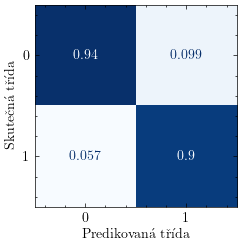

In [16]:
eval_model.load_weights(f"../results/models/Merged_5s.h5")

# Predict the values from the validation dataset
Y_pred = eval_model.predict(X_test)

utils.print_stats(y_test, Y_pred)
utils.plot_confusion_matrix(y_test, Y_pred, normalize="pred")
plt.savefig(f"{fpath}/merged_5s.pdf", format="pdf", bbox_inches="tight")

In [7]:
# sm = SMOTETomek(random_state=42, smote=SMOTE(k_neighbors=cuml.NearestNeighbors(n_neighbors=5)))
# X_res, y_res = sm.fit_resample(X.reshape(len(X), -1), y)
# X_res = X_res.reshape(-1, 32, 32, 3)
#
# with open("../data/augmented_cuml/Merged_5s50_AUG.pkl", "wb") as f:
#     pickle.dump({"X": X_res, "y": y_res}, f)

with open("../data/augmented_cuml/WESAD_5s_AUG.pkl", "rb") as f:
    data = pickle.load(f)
    X_res1, y_res1 = data["X"], data["y"]

with open("../data/augmented_cuml/CLAS_5s_AUG.pkl", "rb") as f:
    data = pickle.load(f)
    X_res2, y_res2 = data["X"], data["y"]

X_res = np.concatenate((X_res1, X_res2), axis=0)
y_res = np.concatenate((y_res1, y_res2), axis=0)

print(X_res.shape, y_res.shape)
print("Label counts: \n", pd.value_counts(y_res))

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.20, random_state=42)
print(X_train_res.shape, X_test_res.shape, y_train_res.shape, y_test_res.shape)

y_train_res = to_categorical(y_train_res, num_classes=2)
y_test_res = to_categorical(y_test_res, num_classes=2)

(20964, 32, 32, 3) (20964,)
Label counts: 
 0    10482
1    10482
dtype: int64
(16771, 32, 32, 3) (4193, 32, 32, 3) (16771,) (4193,)


In [11]:
model_name = "Merged_5s_AUG"
lr = 5e-4
epochs = 100
batch_size = 256

# Train model
train_model_aug, eval_model_aug = efinet.build_graph([32, 32, 3], 2)
trained_model_aug = efinet.train(model=train_model_aug, data=((X_train_res, y_train_res), (X_test_res, y_test_res)),
                                 epochs=epochs, lr=lr, model_name=model_name, batch_size=batch_size)







Epoch 1/100
64/66 [============================>.] - ETA: 0s - loss: 0.3542 - Efficient_CapsNet_loss: 0.1950 - Generator_loss: 0.4060 - Efficient_CapsNet_accuracy: 0.6798
Epoch 1: val_Efficient_CapsNet_accuracy improved from -inf to 0.62771, saving model to ../results\models
66/66 [==============================] - 2s 23ms/step - loss: 0.3525 - Efficient_CapsNet_loss: 0.1936 - Generator_loss: 0.4053 - Efficient_CapsNet_accuracy: 0.6820 - val_loss: 0.3932 - val_Efficient_CapsNet_loss: 0.2470 - val_Generator_loss: 0.3728 - val_Efficient_CapsNet_accuracy: 0.6277 - lr: 5.0000e-04
Epoch 2/100
65/66 [============================>.] - ETA: 0s - loss: 0.2547 - Efficient_CapsNet_loss: 0.1092 - Generator_loss: 0.3713 - Efficient_CapsNet_accuracy: 0.8413
Epoch 2: val_Efficient_CapsNet_accuracy improved from 0.62771 to 0.74720, saving model to ../results\models
66/66 [==============================] - 1s 18ms/step - loss: 0.2546 - Efficient_CapsNet_loss: 0.1090 - Generator_loss: 0.3714 - Eff

In [12]:
print("Train acc: ", np.round(np.max(trained_model_aug.history.history["Efficient_CapsNet_accuracy"]), 4))
print("Val acc: ", np.round(np.max(trained_model_aug.history.history["val_Efficient_CapsNet_accuracy"]), 4))

Train acc:  0.9974
Val acc:  0.9616


Accuracy = 0.9587407584068686
F1 Score = 0.9587406739227833
TPR = 0.9589933995652506
TNR =  0.9590379008746356
AUC = 0.9886113026676042


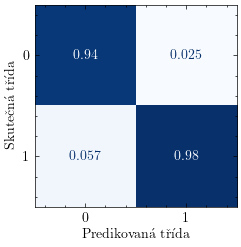

In [13]:
eval_model_aug.load_weights(f"../results/models/Merged_5s_AUG.h5")

# Predict the values from the validation dataset
Y_pred_aug = eval_model_aug.predict(X_test_res)

utils.print_stats(y_test_res, Y_pred_aug)
utils.plot_confusion_matrix(y_test_res, Y_pred_aug)
plt.savefig(f"{fpath}/merged_5s_aug.pdf", format="pdf", bbox_inches="tight")